## CMPE 260 Reinforcement Learning
### Connect 4 game - MultiPlayer connect4

The game can be played in three modes. These are:
   1. Mode 1 - Single Player (Human vs Computer Player)
   2. Mode 2 - Two Players (Both Human)
   3. Mode 3 - Two RL Players (2 Computer Players battle against each other for N iterations)

Where,
   1. Human Player    - Accepts user input
   2. Computer Player - Is of 5 types namely:
                         i. Random       - Picks next move randomly from available locations
                        ii. QLearner     - Picks next move based on QLearning
                       iii. SarsaLearner - Picks next move based on SarsaLearning
                        iv. MonteCarlo   - Picks next move based on MonteCarlo algorithm
                         v. Minimax      - Picks next move based on Minimax algorithm
   3. N iterations     - Number of iterations two computer players battle against each other

Baseline hyper parameters for QLearner, SarsaLearner players are 
   1. QLearner, SarsaLearner epsilon     - 0.2 
   2. QLearner, SarsaLearner alpha       - 0.3
   3. QLearner, SarsaLearner gamma       - 0.9

#### Team Members: Abhishek Bais, Haley Feng, Princy Joy, Shannon Phu

### 1.0 Import libraries, define global variables

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pygame
import random
import time
import numpy as np
import copy

# define some global variables
BLUE = (0, 0, 255)
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BOARD_SIZE = (7,6)

pygame 2.1.0 (SDL 2.0.16, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


### 2.0 Define utility classes to play the connect 4 game

In [3]:
class ColumnFullException(Exception):
    """An exception that will be thrown if a column of the board is full"""
    def __init__(self, value):
        self.value = value
        
    def __str__(self):
        return repr(self.value)   
    
class Slot():
    """A class that represents a single slot on the board"""
    SIZE=80
    def __init__(self, row_index, col_index, width, height, x1, y1):
        """
        Initialize a slot in a given position on the board
        """
        self.content = 0
        self.row_index = row_index
        self.col_index = col_index
        self.width = width
        self.height = height
        self.surface = pygame.Surface((width*2, height*2))
        self.x_pos = x1
        self.y_pos = y1
        
    def get_location(self):
        """ 
        Return the location of the slot on the game board
        """
        return (self.row_index, self.col_index)
    
    def get_position(self):
        """
        Return the x and y positions of the top left corner of the slot on 
        the screen
        """
        return (self.x_pos, self.y_pos)
    
    def set_coin(self, coin):
        """
        Set a coin in the slot, which can be one of two colors
        """
        self.content = coin.get_coin_type()
        
    def check_slot_fill(self):
        """
        Return true iff a coin is placed in the slot
        """
        return (self.content != 0)
    
    def get_content(self):
        """
        Return what is stored in the slot, 0 if it is empty
        """
        return self.content
        
    def draw(self, background):
        """
        Draws a slot on the screen
        """
        pygame.draw.rect(self.surface, GREEN, (0, 0, self.width, self.height))
        pygame.draw.rect(self.surface, WHITE, (1,1,self.width - 2,self.height - 2))
        self.surface = self.surface.convert()
        background.blit(self.surface, (self.x_pos, self.y_pos))

In [4]:
class Board():
    """A class to represent the connect 4 board"""
    
    MARGIN_X = 300
    MARGIN_Y = 150
    
    def __init__(self, num_rows, num_columns):
        """
        Initialize a board with num_rows rows and num_columns columns
        """
        self.container = [[Slot(i, j, Slot.SIZE, Slot.SIZE, 
                                j*Slot.SIZE + Board.MARGIN_X, 
                                i*Slot.SIZE + Board.MARGIN_Y) for j in range(num_columns)] for i in range(num_rows)]
        self.num_rows = num_rows
        self.num_columns = num_columns
        self.total_slots = num_rows * num_columns
        self.num_slots_filled = 0
        self.last_visited_nodes = []
        self.last_value = 0
        
        self.state = [[0 for j in range(num_columns)] for i in range(num_rows)]
        self.prev_state = None
        self.prev_move = (None, None, None)
        # initialize the internal graph representation of the board
        # where every node is connected to all the other nodes in the 8 
        # directions surrounding it to which it already contains pointers
        self.representation = [[SlotTrackerNode() for j in range(num_columns)] for i in range(num_rows)]
        for i in range(num_rows):
            prev_row_index = i - 1
            next_row_index = i + 1
            for j in range(num_columns):
                prev_col_index = j - 1
                next_col_index = j + 1
                current_node = self.representation[i][j]
                if prev_row_index >= 0 and prev_col_index >=0:
                    current_node.top_left = self.representation[prev_row_index][prev_col_index]
                if prev_row_index >=0:
                    current_node.top = self.representation[prev_row_index][j]
                if prev_row_index >=0 and next_col_index < num_columns:
                    current_node.top_right = self.representation[prev_row_index][next_col_index]
                if prev_col_index >= 0:
                    current_node.left = self.representation[i][prev_col_index]
                    
                if next_col_index < num_columns:
                    current_node.right = self.representation[i][next_col_index]
                if next_row_index < num_rows and prev_col_index >= 0:
                    current_node.bottom_left = self.representation[next_row_index][prev_col_index]
                    
                if next_row_index < num_rows:
                    current_node.bottom = self.representation[next_row_index][j]
                if next_row_index < num_rows and next_col_index < num_columns:
                    current_node.bottom_right = self.representation[next_row_index][next_col_index]    
    
    def draw(self, background):
        """
        Method to draw the entire board on the screen
        """
        for i in range(self.num_rows):
            for j in range(self.num_columns):
                self.container[i][j].draw(background)
                
    def get_slot(self, row_index, col_index):
        """
        Return a slot on the board given its row and column indices
        """
        return self.container[row_index][col_index]
    
    def check_column_fill(self, col_num):
        """
        Return True iff the column col_num on the board is filled up
        """
        for i in range(len(self.container)):
            # if a slot isn't filled then the column is not filled
            if not self.container[i][col_num].check_slot_fill():
                return False
        return True
    
    def insert_coin(self, coin, background, game_logic):
        """
        Insert the coin in the board and update board state and
        internal representation
        """
        col_num = coin.get_column()
        if not self.check_column_fill(col_num):
            row_index = self.determine_row_to_insert(col_num)
            self.container[row_index][col_num].set_coin(coin)
            if (self.prev_move[0] == None):
                self.prev_state = [[0 for j in range(self.num_columns)] for i in range(self.num_rows)]
            else:
                (prev_row, prev_col, value) = self.prev_move
                self.prev_state[prev_row][prev_col] = value
            self.prev_move = (row_index, col_num, coin.get_coin_type())    
            self.state[row_index][col_num] = coin.get_coin_type()
            self.update_slot_tracker(row_index, col_num, coin.get_coin_type())
            self.num_slots_filled += 1
            self.last_value = coin.get_coin_type()
            coin.drop(background, row_index)
            
        else:
            raise ColumnFullException('Column is already filled!')
        
        result = game_logic.check_game_over()
        
        return result
        
    def determine_row_to_insert(self, col_num):
        """
        Determine the row in which the coin can be dropped into
        """
        for i in range(len(self.container)):
            if self.container[i][col_num].check_slot_fill():
                return (i - 1)
        
        return self.num_rows - 1
                
    def get_dimensions(self):
        """
        Return the dimensions of the board
        """
        return (self.num_rows, self.num_columns)
    
    def check_board_filled(self):
        """
        Return true iff the board is completely filled
        """
        return (self.total_slots == self.num_slots_filled)
            
    def get_representation(self):
        """
        Return the internal graph representation of the board
        """
        return self.representation
    
    def get_available_actions(self):
        """
        Return the available moves
        """
        actions = []
        for i in range(self.num_columns):
            if (not self.check_column_fill(i)):
                actions.append(i)
        return actions
    
    def get_state(self):
        """
        Return the 2d list numerical representation of the board
        """
        result = tuple(tuple(x) for x in self.state)
        
        return result
    
    def get_prev_state(self):
        """
        Return the previous state of the board
        """
        result = tuple(tuple(x) for x in self.prev_state)
        
        return result
    
    def get_last_filled_information(self):
        """
        Return the last visited nodes during the update step of the scores
        within the internal graph representation and also return the last 
        coin type inserted into the board
        """
        return (self.last_visited_nodes, self.last_value)
    
    def update_slot_tracker(self, i, j, coin_type):
        """
        Update the internal graph representation based on the latest insertion
        into the board
        """
        self.last_visited_nodes = []
        start_node = self.representation[i][j]
        start_node.value = coin_type
        self.traverse(start_node, coin_type, i, j, self.last_visited_nodes)
        # reset all the nodes as if it hadn't been visited
        for indices in self.last_visited_nodes:
            self.representation[indices[0]][indices[1]].visited = False
            
        
    def traverse(self, current_node, desired_value, i, j, visited_nodes):
        """
        Recursively update the scores of the relevant nodes based on its
        adjacent nodes (slots). If a coin type 1 is inserted into the board in 
        some position i, j, then update all adjacent slots that contain 1 with
        an updated score reflecting how many slots have 1 in a row in the top
        left, top right, etc directions
        """
        current_node.visited = True
        visited_nodes.append((i,j))
        if current_node.top_left:
            top_left_node = current_node.top_left
            if top_left_node.value == desired_value:
                current_node.top_left_score = top_left_node.top_left_score + 1
                if not top_left_node.visited:
                    self.traverse(top_left_node, desired_value, i - 1, j - 1, visited_nodes)
        if current_node.top:
            top_node = current_node.top
            if top_node.value == desired_value:
                current_node.top_score = top_node.top_score + 1
                if not top_node.visited:
                    self.traverse(top_node, desired_value, i - 1, j, visited_nodes)  
        if current_node.top_right:
            top_right_node = current_node.top_right
            if top_right_node.value == desired_value:
                current_node.top_right_score = top_right_node.top_right_score + 1
                if not top_right_node.visited:
                    self.traverse(top_right_node, desired_value, i - 1, j + 1, visited_nodes)          

        if current_node.left:
            left_node = current_node.left
            if left_node.value == desired_value:
                current_node.left_score = left_node.left_score + 1
                if not left_node.visited:
                    self.traverse(left_node, desired_value, i, j - 1, visited_nodes)    
                    
        if current_node.right:
            right_node = current_node.right
            if right_node.value == desired_value:
                current_node.right_score = right_node.right_score + 1
                if not right_node.visited:
                    self.traverse(right_node, desired_value, i, j + 1, visited_nodes)
                    
        if current_node.bottom_left:
            bottom_left_node = current_node.bottom_left
            if bottom_left_node.value == desired_value:
                current_node.bottom_left_score = bottom_left_node.bottom_left_score + 1
                if not bottom_left_node.visited:
                    self.traverse(bottom_left_node, desired_value, i + 1, j - 1, visited_nodes)
        
        if current_node.bottom:
            bottom_node = current_node.bottom
            if bottom_node.value == desired_value:
                current_node.bottom_score = bottom_node.bottom_score + 1
                if not bottom_node.visited:
                    self.traverse(bottom_node, desired_value, i + 1, j, visited_nodes)
                    
        if current_node.bottom_right:
            bottom_right_node = current_node.bottom_right
            if bottom_right_node.value == desired_value:
                current_node.bottom_right_score = bottom_right_node.bottom_right_score + 1
                if not bottom_right_node.visited:
                    self.traverse(bottom_right_node, desired_value, i + 1, j + 1, visited_nodes)

In [5]:
class Coin():
    """A class that represents the coin pieces used in connect 4"""
    
    RADIUS = 30
    
    def __init__(self, coin_type):
        """
        Initialize a coin with a given coin_type 
        (integer that represents its color)
        """
        self.coin_type = coin_type
        self.surface = pygame.Surface((Slot.SIZE - 3, Slot.SIZE - 3))
        if (self.coin_type == 1):
            self.color = BLUE
        else:
            self.color = RED
    
    def set_position(self, x1, y1):
        """
        Set the position of the coin on the screen
        """
        self.x_pos = x1
        self.y_pos = y1
        
    def set_column(self, col):
        """
        Set the column on the board in which the coin belongs
        """
        self.col = col
        
    def get_column(self):
        """
        Get the column on the board in which the coin belongs in
        """
        return self.col
    
    def set_row(self, row):
        """
        Set the row on the board where the coin is
        """
        self.row = row
        
    def get_row(self):
        """
        Get the row on the board in which the coin belongs
        """
        return self.row
    
    def move_right(self, background, step=1):
        """
        Move the coin to the column that is right of its current column
        """
        self.set_column(self.col + 1)
        self.surface.fill((0,0,0))
        background.blit(self.surface, (self.x_pos, self.y_pos))
        self.set_position(self.x_pos + step * Slot.SIZE, self.y_pos)
        self.draw(background)
            
    def move_left(self, background):
        """
        Move the coin to the column that is left of its current column
        """
        self.set_column(self.col - 1)
        self.surface.fill((0,0,0))
        background.blit(self.surface, (self.x_pos, self.y_pos))
        self.set_position(self.x_pos - Slot.SIZE, self.y_pos)
        self.draw(background)  
            
    def drop(self, background, row_num):
        """
        Drop the coin to the bottom most possible slot in its column
        """
        self.set_row(row_num)
        self.surface.fill((0,0,0))
        background.blit(self.surface, (self.x_pos, self.y_pos))
        self.set_position(self.x_pos, self.y_pos + ((self.row + 1) * Slot.SIZE))
        self.surface.fill((255,255,255))
        background.blit(self.surface, (self.x_pos, self.y_pos))
        self.draw(background) 
            
    def get_coin_type(self):
        """
        Return the coin type
        """
        return self.coin_type
    
    def draw(self, background):
        """
        Draw the coin on the screen
        """
        pygame.draw.circle(self.surface, self.color, (Slot.SIZE // 2, Slot.SIZE // 2), Coin.RADIUS)
        self.surface = self.surface.convert()
        background.blit(self.surface, (self.x_pos, self.y_pos))    

In [6]:
class SlotTrackerNode():
    """A class that that represents the node in the internal graph 
    representation of the game board"""
    
    def __init__(self):
        """
        Initialize the SlotTrackerNode with pointers to Nodes in all 
        8 directions surrounding along with a score count in each direction
        """
        self.top_left = None
        self.top_right = None
        self.top = None
        self.left = None
        self.right = None
        self.bottom_left = None
        self.bottom = None
        self.bottom_right = None       
        self.top_left_score = 1
        self.top_right_score = 1
        self.top_score = 1
        self.left_score = 1
        self.right_score = 1
        self.bottom_left_score = 1
        self.bottom_score = 1
        self.bottom_right_score = 1
        self.value = 0
        self.visited = False

### 3.0 Define players who will play the connect 4 game
#### Two types of players are supported
1. Human Player    - Accepts user input
2. Computer Player - Is of 5 types namely:
                     i.   Random       - Picks next move randomly from available locations
                     ii.  QLearner     - Picks next move based on QLearning
                     iii. SarsaLearner - Picks next move based on SarsaLearning
                     iv.  MonteCarlo   - Picks next move based on MonteCarlo algorithm
                     v.   Minimax      - Picks next move based on Minimax algorithm

In [7]:
class Player():
    """A class that represents a player in the game"""
    
    def __init__(self, coin_type):
        """
        Initialize a player with their coin type
        """
        self.coin_type = coin_type
        
    def complete_move(self):
        """
        A method to make a move and update any learning parameters if any
        """
        pass
    
    def get_coin_type(self):
        """
        Return the coin type of the player
        """
        return self.coin_type
    
    def set_coin_type(self, coin_type):
        """
        Set the coin type of a player
        """
        self.coin_type = coin_type
        
class HumanPlayer(Player):
    """A class that represents a human player in the game"""
    
    def __init__(self, coin_type):
        """
        Initialize a human player with their coin type
        """
        Player.__init__(self, coin_type)
        
class ComputerPlayer(Player):
    """A class that represents an AI player in the game"""
    
    def __init__(self, coin_type, player_type):
        """
        Initialize an AI with the proper type which are one of Random, 
        Q learner and Sarsa learner
        """
        if (player_type == "qlearner"):
            self.player = QLearningPlayer(coin_type)
        elif (player_type == "sarsalearner"):
            self.player = SarsaLearningPlayer(coin_type)
        elif (player_type == "montecarlo"):
            self.player = MonteCarloPlayer(coin_type)
        elif (player_type == "minimax"):
            self.player = MiniMaxPlayer(coin_type)
        else:
            self.player = RandomPlayer(coin_type)
            
    def complete_move(self, coin, board, game_logic, background):
        """
        Move the coin and decide which slot to drop it in and learn from the
        chosen move
        """
        actions = board.get_available_actions()
        state = board.get_state()
        chosen_action = self.choose_action(state, actions, coin, board, game_logic, background)
        coin.move_right(background, chosen_action)
        coin.set_column(chosen_action)
        game_over = board.insert_coin(coin, background, game_logic)
        self.player.learn(board, actions, chosen_action, game_over, game_logic)
        
        return game_over
    
    def get_coin_type(self):
        """
        Return the coin type of the AI player
        """
        return self.player.get_coin_type()
    
    def choose_action(self, state, actions, coin=None, board=None, game_logic=None, background=None):
        """
        Choose an action (which slot to drop in) based on the state of the
        board
        """
        return self.player.choose_action(state, actions, coin, board, game_logic, background)
        
class RandomPlayer(Player):
    """A class that represents a computer that selects random moves based on the moves available"""
    
    def __init__(self, coin_type):
        """
        Initialize the computer player
        """
        Player.__init__(self, coin_type)
        
    def choose_action(self, state, actions, coin, board, game_logic, background):
        """
        Choose a random action based on the available actions
        """
        return random.choice(actions)
                
    def learn(self, board, actions, chosen_action, game_over, game_logic):
        """
        The random player does not learn from its actions
        """
        pass

In [8]:
class QLearningPlayer(Player):
    """A class that represents an AI using Q-learning algorithm"""
    
    def __init__(self, coin_type, epsilon=0.2, alpha=0.3, gamma=0.9):
        """
        Initialize a Q-learner with parameters epsilon, alpha and gamma
        and its coin type
        """
        Player.__init__(self, coin_type)
        self.q = {}
        self.epsilon = epsilon # e-greedy chance of random exploration
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor for future rewards 
        
    def getQ(self, state, action):
        """
        Return a probability for a given state and action where the greater
        the probability the better the move
        """
        # encourage exploration; "optimistic" 1.0 initial values
        if self.q.get((state, action)) is None:
            self.q[(state, action)] = 1.0
        return self.q.get((state, action))    
        
    def choose_action(self, state, actions, coin, board, game_logic, background):
        """
        Return an action based on the best move recommendation by the current
        Q-Table with a epsilon chance of trying out a new move
        """
        current_state = state

        if random.random() < self.epsilon: # explore!
            chosen_action = random.choice(actions)
            return chosen_action

        qs = [self.getQ(current_state, a) for a in actions]
        maxQ = max(qs)

        if qs.count(maxQ) > 1:
            # more than 1 best option; choose among them randomly
            best_options = [i for i in range(len(actions)) if qs[i] == maxQ]
            i = random.choice(best_options)
        else:
            i = qs.index(maxQ)

        return actions[i]
    
    def learn(self, board, actions, chosen_action, game_over, game_logic):
        """
        Determine the reward based on its current chosen action and update
        the Q table using the reward recieved and the maximum future reward
        based on the resulting state due to the chosen action
        """
        reward = 0
        if (game_over):
            win_value = game_logic.get_winner()
            if win_value == 0:
                reward = 0.5
            elif win_value == self.coin_type:
                reward = 1
            else:
                reward = -2
        prev_state = board.get_prev_state()
        prev = self.getQ(prev_state, chosen_action)
        result_state = board.get_state()
        maxqnew = max([self.getQ(result_state, a) for a in actions])
        self.q[(prev_state, chosen_action)] = prev + self.alpha * ((reward + self.gamma*maxqnew) - prev)

In [9]:
class SarsaLearningPlayer(Player):
    """A class that represents an AI using Sarsa-learning algorithm"""
    
    def __init__(self, coin_type, epsilon=0.2, alpha=0.3, gamma=0.9):
        """
        Initialize a sarsa-learner with parameters epsilon, alpha and gamma
        and its coin type
        """
        Player.__init__(self, coin_type)
        self.q = {}
        self.epsilon = epsilon # e-greedy chance of random exploration
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor for future rewards 
        
    def getQ(self, state, action):
        """
        Return a probability for a given state and action where the greater
        the probability the better the move
        """
        # encourage exploration; "optimistic" 1.0 initial values
        if self.q.get((state, action)) is None:
            self.q[(state, action)] = 1.0
        return self.q.get((state, action))    
        
    def choose_action(self, state, actions, coin, board, game_logic, background):
        """
        Return an action based on the best move recommendation by the current
        Q-Table with a epsilon chance of trying out a new move
        """
        current_state = state

        if random.random() < self.epsilon: # explore!
            chosen_action = random.choice(actions)
            return chosen_action

        qs = [self.getQ(current_state, a) for a in actions]
        maxQ = max(qs)

        if qs.count(maxQ) > 1:
            # more than 1 best option; choose among them randomly
            best_options = [i for i in range(len(actions)) if qs[i] == maxQ]
            i = random.choice(best_options)
        else:
            i = qs.index(maxQ)

        return actions[i]
    
    def learn(self, board, actions, chosen_action, game_over, game_logic):
        """
        Determine the reward based on its current chosen action and update
        the Q table using the reward recieved and the exploring future reward
        based on the resulting state due to the chosen action
        """
        reward = 0
        if (game_over):
            win_value = game_logic.get_winner()
            if win_value == 0:
                reward = 0.5
            elif win_value == self.coin_type:
                reward = 1
            else:
                reward = -2
        prev_state = board.get_prev_state()
        prev = self.getQ(prev_state, chosen_action)
        result_state = board.get_state()
        qnew = self.getQ(result_state, chosen_action)
        self.q[(prev_state, chosen_action)] = prev + self.alpha * ((reward + self.gamma*qnew) - prev)

In [10]:
# Adapted from: http://mcts.ai/code/python.html by Christopher Yong
# https://replit.com/talk/challenge/Connect-4-AI-using-Monte-Carlo-Tree-Search/10640
# https://jyopari.github.io/MCTS

class Node:
    def __init__(self, board, parent=None, move=None):
        self.board = copy.deepcopy(board)
        self.parent = parent
        self.move = move
        self.untriedMoves = board.get_available_actions()
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        
    # return child with largest UCT value
    def selection(self):
        # Upper Confidence bounds applied to Trees
        # uct = Xj + sqrt(In(N)/Nj)
        # Xj is the win ratio for a child node
        # N is the number of times the parent node has been visited
        # Nj is the number of times the child node has been visited.
        # Xj represents exploitation, as it is a large value when the win rate is high
        # Second term represents exploration, as it is large when the number of visits for that node have been low.
        uct = lambda x: x.wins / x.visits + np.sqrt(2 * np.log(self.visits) / x.visits)
        return sorted(self.childNodes, key=uct)[-1]

    # return child when move is taken
    # remove move from current node
    def expand(self, move, board):
        child = Node(board=board,
                     parent=self,
                     move=move)
        #self.untriedMoves.remove(move) - check this with other comment in mcts
        self.childNodes.append(child)
        return child

    def update(self, result):
        self.wins += result
        self.visits += 1

###################################
class MonteCarloPlayer(Player):
    """A class that represents an AI using montecarlo algorithm"""
    
    def __init__(self, coin_type):
        """
        Initialize a montecarlo player with coin type
        """
        self.currentNode = None
        Player.__init__(self, coin_type) 
    
    def choose_action(self, state, actions, coin, board, game_logic, background):
        self.currentNode = Node(board)
        return self.mcts(board, 20000, self.currentNode, coin, game_logic, background, 5)

    def mcts(self, board, itermax, currentNode, coin, game_logic, background, timeout=5):
        rootnode = Node(board=board)
        if currentNode is not None: rootnode = currentNode

        start = time.perf_counter()
        for i in range(itermax):
            node = rootnode
            state = copy.deepcopy(board)
            
            # selection
            while node.untriedMoves == [] and node.childNodes != []:
                # keep going down the tree based on best UCT values until terminal or unexpanded node
                node = node.selection()
                col = random.choice(state.get_available_actions())
                coin.set_column(col)
                game_over = board.insert_coin(coin, background, game_logic)
        
            # expand
            if node.untriedMoves != []:
                #col = random.choice(node.untriedMoves) - check why this is filled already
                col = random.choice(state.get_available_actions())
                coin.set_column(col)
                game_over = state.insert_coin(coin, background, game_logic)
                node = node.expand(col, board)

            # rollout
            while board.get_available_actions():
                col = random.choice(board.get_available_actions())
                coin.set_column(col)
                game_over = state.insert_coin(coin, background, game_logic)
                if (game_over > 0):
                    break        

            # backpropagate
            while node is not None:
                node.update(game_over)
                node = node.parent

            duration = time.perf_counter() - start
            if duration > timeout: break

        win_ratio = lambda x: x.wins / x.visits
        sortedChildNodes = sorted(rootnode.childNodes, key=win_ratio)[::-1]
        return sortedChildNodes[0].move
    
    def learn(self, board, actions, chosen_action, game_over, game_logic):
        """
        A method to make a move and update any learning parameters if any
        """
        pass

### 3.0 Define the game winning conditions

In [11]:
class GameLogic():
    """A class that handles win conditions and determines winner"""
    WIN_SEQUENCE_LENGTH = 4
    
    def __init__(self, board):
        """
        Initialize the GameLogic object with a reference to the game board
        """
        self.board = board
        (num_rows, num_columns) = self.board.get_dimensions()
        self.board_rows = num_rows
        self.board_cols = num_columns
        self.winner_value = 0
    
    def check_game_over(self):
        """
        Check whether the game is over which can be because of a tie or one
        of two players have won
        """
        (last_visited_nodes, player_value) = self.board.get_last_filled_information()
        representation = self.board.get_representation()        
        player_won = self.search_win(last_visited_nodes, representation)
        if player_won:
            self.winner_value = player_value
            
        return ( player_won or self.board.check_board_filled() )
           
    def search_win(self, last_visited_nodes, representation):
        """
        Determine whether one of the players have won
        """
        for indices in last_visited_nodes:
            current_node = representation[indices[0]][indices[1]]
            if ( current_node.top_left_score == GameLogic.WIN_SEQUENCE_LENGTH or 
                 current_node.top_score == GameLogic.WIN_SEQUENCE_LENGTH or
                 current_node.top_right_score == GameLogic.WIN_SEQUENCE_LENGTH or
                 current_node.left_score == GameLogic.WIN_SEQUENCE_LENGTH or
                 current_node.right_score == GameLogic.WIN_SEQUENCE_LENGTH or
                 current_node.bottom_left_score == GameLogic.WIN_SEQUENCE_LENGTH or
                 current_node.bottom_score == GameLogic.WIN_SEQUENCE_LENGTH or
                 current_node.bottom_right_score == GameLogic.WIN_SEQUENCE_LENGTH ):
                return True
            
        return False
    
    def determine_winner_name(self):
        """
        Return the winner's name
        """
        if (self.winner_value == 1):
            return "BLUE"
        elif (self.winner_value == 2):
            return "RED"
        else:
            return "TIE"
        
    def get_winner(self):
        """
        Return the winner coin type value
        """
        return self.winner_value

### 4.0 Configure the game 

In [12]:
class GameView(object):
    """A class that represents the displays in the game"""

    def __init__(self, width=640, height=400, fps=30):
        """Initialize pygame, window, background, font,...
        """
        pygame.init()
        pygame.display.set_caption("Press ESC to quit")
        self.width = width
        self.height = height
        self.screen = pygame.display.set_mode((self.width, self.height), pygame.DOUBLEBUF)
        self.background = pygame.Surface(self.screen.get_size()).convert()
        self.clock = pygame.time.Clock()
        self.fps = fps
        self.playtime = 0.0
        self.font = pygame.font.SysFont('mono', 20, bold=True)
        self.trainedComputer = None
        self.win_list = [0,0]
        
    def initialize_game_variables(self, game_mode, p1, p2):
        """
        Initialize the game board and the GameLogic object
        """
        self.game_board = Board(BOARD_SIZE[0], BOARD_SIZE[1])
        (self.board_rows, self.board_cols) = self.game_board.get_dimensions()
        self.game_logic = GameLogic(self.game_board)
        first_coin_type = random.randint(1,2)
        second_coin_type = 2 if first_coin_type == 1 else 1 
        
        if game_mode == "single":
            self.p1 = p1
            if (self.trainedComputer == None):
                self.p2 = ComputerPlayer(second_coin_type, "qlearner")
                self.trainedComputer = self.p2
            else:
                self.trainedComputer.set_coin_type(second_coin_type)
                self.p2 = self.trainedComputer
        elif game_mode == "two_player":
            self.p1 = p1
            self.p2 = p2
        else:
            self.trainedComputer = None
            self.win_list = [0,0]
            self.p1 = p1
            self.p2 = p2 
            
    def main_menu(self, PlayerType_1="", PlayerType_2="", iterations=20):
        """
        Display the main menu screen
        """
        main_menu = True
        play_game = False
        game_mode = ""
        self.background.fill(WHITE)
        self.draw_menu()
        
        while main_menu:            
            for event in pygame.event.get():
                if event.type == pygame.MOUSEBUTTONDOWN:
                    pos = pygame.mouse.get_pos()
                    if self.rect1.collidepoint(pos):
                        play_game = True
                        main_menu = False
                        game_mode = "two_player"
                        
                    elif self.rect2.collidepoint(pos):
                        play_game = True
                        main_menu = False
                        game_mode = "single"
                        
                    elif self.rect3.collidepoint(pos):
                        play_game = True
                        main_menu = False
                        game_mode = "train"
                        
                    elif self.rect4.collidepoint(pos):
                        main_menu = False
                            
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:
                        main_menu = False

                               
            milliseconds = self.clock.tick(self.fps)
            self.playtime += milliseconds / 1000.0
            pygame.display.flip()
            self.screen.blit(self.background, (0, 0))            
        
        first_coin_type = random.randint(1,2)
        second_coin_type = 2 if first_coin_type == 1 else 1 
        p1 = None
        p2 = None
        if (game_mode == "single"):
            p1 = HumanPlayer(first_coin_type)
        elif game_mode == "two_player":
            p1 = HumanPlayer(first_coin_type)
            p2 = HumanPlayer(second_coin_type)
        else:
            p1 = ComputerPlayer(first_coin_type, PlayerType_1)
            p2 = ComputerPlayer(second_coin_type, PlayerType_2)
        
        if not play_game:
            pygame.quit()
            
        elif game_mode == "train":
            self.run(game_mode, p1, p2, iterations)
        
        else:
            self.run(game_mode, p1, p2)

    def run(self, game_mode, p1=None, p2=None, iterations=1):
        """
        Main loop in the game
        """
        p1_win   = 0
        p2_win   = 0
        draw     = 0
        count    = 0
        p1_wins  = []
        p2_wins  = []
        draws    = []
        counts   = []
        num_games = iterations
        
        while (iterations > 0):
            self.initialize_game_variables(game_mode, p1, p2)
            self.background.fill(BLACK)
            self.game_board.draw(self.background)
            game_over = False
            turn_ended = False
            uninitialized = True
            current_type = random.randint(1,2)
            if game_mode == "single":
                human_turn = (self.p1.get_coin_type() == current_type)
                
            elif game_mode == "two_player":
                human_turn = True
                
            else:
                human_turn = False
                
            p1_turn = (self.p1.get_coin_type() == current_type)
                
            (first_slot_X, first_slot_Y) = self.game_board.get_slot(0,0).get_position()
            coin = Coin(current_type)
            game_over_screen = False
            while not game_over:
                         
                if uninitialized:
                    coin = Coin(current_type)
                    coin.set_position(first_slot_X, first_slot_Y - Slot.SIZE)
                    coin.set_column(0)
                    uninitialized = False
                    coin_inserted = False
                                   
                coin.draw(self.background)
                
                current_player = self.p1 if p1_turn else self.p2
                
                if not human_turn:
                    game_over = current_player.complete_move(coin, self.game_board, self.game_logic, self.background)
                    coin_inserted = True
                    uninitialized = True
                    
                # handle the keyboard events
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        game_over = True
                    elif event.type == pygame.KEYDOWN:
                        if event.key == pygame.K_ESCAPE:
                            game_over = True
                        if event.key == pygame.K_RIGHT and human_turn:
                            if (coin.get_column() + 1 < self.board_cols):
                                coin.move_right(self.background)
                            
                        elif event.key == pygame.K_LEFT and human_turn:
                            if (coin.get_column() - 1 >= 0):
                                coin.move_left(self.background)
                            
                        elif event.key == pygame.K_RETURN and human_turn and not coin_inserted:
                            try:
                                game_over = self.game_board.insert_coin(coin, self.background, self.game_logic)
                                current_player.complete_move()
                                uninitialized = True
                                coin_inserted = True
                                
                            except ColumnFullException as e:
                                pass
                
                if game_over:
                    winner = self.game_logic.determine_winner_name()
                    winner_value = self.game_logic.get_winner()
                    if (winner_value > 0 and game_mode == "train"):
                        self.win_list[winner_value - 1] += 1
                    game_over_screen = True
                    
                    if (winner == "RED"):
                        p1_win = p1_win + 1
                    elif (winner == "BLUE"):
                        p2_win = p2_win + 1
                    else:
                        draw = draw + 1
                    count = count + 1
                    
                    p1_wins.append(p1_win*100.0/num_games)
                    p2_wins.append(p2_win*100.0/num_games)
                    draws.append(draw*100.0/num_games)
                    counts.append(count*num_games)

                if coin_inserted:
                    if game_mode == "single":
                        human_turn = not human_turn
                    current_type = 1 if current_type == 2 else 2 
                    p1_turn = not p1_turn
                         
                milliseconds = self.clock.tick(self.fps)
                self.playtime += milliseconds / 1000.0
                pygame.display.flip()
                self.screen.blit(self.background, (0, 0))
                
            iterations -= 1
            
        if game_mode == "train":        
            plt.ylabel('Game outcomes in %')
            plt.xlabel('Game number')
            plt.plot(counts, draws, 'r-', label='Draw')
            plt.plot(counts, p1_wins, 'g-', label='Player 1 wins')
            plt.plot(counts, p2_wins, 'b-', label='Player 2 wins')
            plt.legend(loc="best", shadow=True, fancybox=True, framealpha =0.7)
            
            index = self.win_list.index(max(self.win_list))
            self.trainedComputer = self.p1 if index == 0 else self.p2
            self.main_menu()
        
        else:
            self.game_over_view(winner)
    
    def draw_menu(self):
        """
        Draw the elements for the main menu screen
        """
        font = pygame.font.SysFont('mono', 60, bold=True)
        self.title_surface = font.render('CONNECT 4', True, BLACK)
        fw, fh = font.size('CONNECT 4')
        self.background.blit(self.title_surface, ((self.width - fw) // 2, 150))
        two_player_text = '2 Player Mode'
        computer_player_text = 'vs Computer'
        train_text = 'Train Computer'
        quit_text = 'QUIT'
        font = pygame.font.SysFont('mono', 40, bold=True)
        
        self.play_surface = font.render(two_player_text, True, BLACK)
        fw, fh = font.size(two_player_text)     
        self.rect1 = self.play_surface.get_rect(topleft=((self.width - fw) // 2, 300))
        self.background.blit(self.play_surface, ((self.width - fw) // 2, 300) )
        
        computer_play_surface = font.render(computer_player_text, True, BLACK)
        fw, fh = font.size(computer_player_text)     
        self.rect2 = computer_play_surface.get_rect(topleft=((self.width - fw) // 2, 350))
        self.background.blit(computer_play_surface, ((self.width - fw) // 2, 350) )    
        
        self.train_surface = font.render(train_text, True, BLACK)
        fw, fh = font.size(train_text)        
        self.rect3 = self.train_surface.get_rect(topleft=((self.width - fw) // 2, 400))
        self.background.blit(self.train_surface, ((self.width - fw) // 2, 400) )        
        
        self.quit_surface = font.render(quit_text, True, BLACK)
        fw, fh = font.size(quit_text)        
        self.rect4 = self.quit_surface.get_rect(topleft=((self.width - fw) // 2, 450))
        self.background.blit(self.quit_surface, ((self.width - fw) // 2, 450) )   
        
    def game_over_view(self, winner):
        """
        Display the game over screen
        """
        game_over_screen = True
        main_menu = False
        self.background.fill(WHITE)
        self.draw_game_over(winner)
        
        while game_over_screen:            
            for event in pygame.event.get():
                if event.type == pygame.MOUSEBUTTONDOWN:
                    if self.rect1.collidepoint(pygame.mouse.get_pos()):
                        main_menu = True
                        game_over_screen = False
                        
                    elif self.rect2.collidepoint(pygame.mouse.get_pos()):
                        game_over_screen = False
                            
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:
                        game_over_screen = False

                               
            milliseconds = self.clock.tick(self.fps)
            self.playtime += milliseconds / 1000.0
            pygame.display.flip()
            self.screen.blit(self.background, (0, 0))            
            
        if not main_menu:
            pygame.quit()
            
        else:
            self.main_menu()        
           
    def draw_game_over(self, winner):
        """
        Draw the elements for the game over screen
        """        
        font = pygame.font.SysFont('mono', 60, bold=True)
        game_over_text = 'GAME OVER'
        self.title_surface = font.render(game_over_text, True, GREEN)
        fw, fh = font.size(game_over_text)
        self.background.blit(self.title_surface, ((self.width - fw) // 2, 150))
        play_again_text = 'Return to Main Menu'
        quit_text = 'Quit'
        if winner != 'TIE':
            winner_text = winner + " wins!"
        else:
            winner_text = "It was a " + winner + "!"
        font = pygame.font.SysFont('mono', 40, bold=True)
        winner_surface = font.render(winner_text, True, BLACK)
        fw, fh = font.size(winner_text)
        self.background.blit(winner_surface, ((self.width - fw) // 2, 300) )
        
        font = pygame.font.SysFont('mono', 40, bold=False)
        self.play_surface = font.render(play_again_text, True, (0,  0, 0))       
        fw, fh = font.size(play_again_text)     
        self.rect1 = self.play_surface.get_rect(topleft=((self.width - fw) // 2, 360))
        self.background.blit(self.play_surface, ((self.width - fw) // 2, 360) )
        
        self.quit_surface = font.render(quit_text, True, (0,  0, 0))
        fw, fh = font.size(quit_text)        
        self.rect2 = self.quit_surface.get_rect(topleft=((self.width - fw) // 2, 410))
        self.background.blit(self.quit_surface, ((self.width - fw) // 2, 410) )

### 5.0 Play the game 

#### 5.1 2 RL players - QLearner, Random battle over 20 games

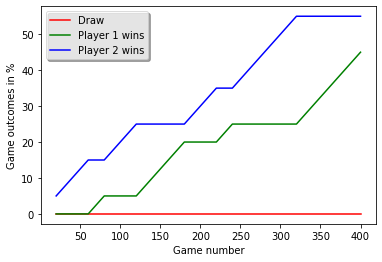

In [13]:
if __name__ == "__main__":
    num_games = 20
    PlayerType_1 = "qlearner"
    PlayerType_2 = "random"
    GameView(1200, 760).main_menu(PlayerType_1, PlayerType_2, num_games)

#### 5.2 2 RL players - SarsaLearner, Random battle over 20 games

In [ ]:
if __name__ == "__main__":
    num_games = 20
    PlayerType_1 = "sarsalearner"
    PlayerType_2 = "random"
    GameView(1200, 760).main_menu(PlayerType_1, PlayerType_2, num_games)

#### 5.3 2 RL players - QLearner, SarsaLearner battle over 20 games

In [ ]:
if __name__ == "__main__":
    num_games = 20
    PlayerType_1 = "qlearner"
    PlayerType_2 = "sarsalearner"
    GameView(1200, 760).main_menu(PlayerType_1, PlayerType_2, num_games)

#### 5.4 2 RL players - Montecarlo, Random battle over 20 games

In [ ]:
if __name__ == "__main__":
    num_games = 20
    PlayerType_1 = "montecarlo"
    PlayerType_2 = "random"
    GameView(1200, 760).main_menu(PlayerType_1, PlayerType_2, num_games)

#### 5.5 2 RL players - QLearner, MonteCarlo battle over 20 games

In [ ]:
if __name__ == "__main__":
    num_games = 20
    PlayerType_1 = "qlearner"
    PlayerType_2 = "montecarlo"
    GameView(1200, 760).main_menu(PlayerType_1, PlayerType_2, num_games)

#### 5.6 2 RL players - SarsaLearner, Montecarlo battle over 20 games

In [ ]:
if __name__ == "__main__":
    num_games = 20
    PlayerType_1 = "sarsalearner"
    PlayerType_2 = "montecarlo"
    GameView(1200, 760).main_menu(PlayerType_1, PlayerType_2, num_games)

#### 5.7 2 RL players - Minimax, Random battle over 20 games

In [ ]:
if __name__ == "__main__":
    num_games = 20
    PlayerType_1 = "minimax"
    PlayerType_2 = "random"
    GameView(1200, 760).main_menu(PlayerType_1, PlayerType_2, num_games)

#### 5.8 2 RL players - Qlearner, Minimax battle over 20 games

In [ ]:
if __name__ == "__main__":
    num_games = 20
    PlayerType_1 = "qlearner"
    PlayerType_2 = "minimax"
    GameView(1200, 760).main_menu(PlayerType_1, PlayerType_2, num_games)

#### 5.9 2 RL players - SarsaLearner, Minimax battle over 20 games

In [ ]:
if __name__ == "__main__":
    num_games = 20
    PlayerType_1 = "sarsalearner"
    PlayerType_2 = "minimax"
    GameView(1200, 760).main_menu(PlayerType_1, PlayerType_2, num_games)

### 6.0 Hyper parameter tuned runs
Baseline hyper parameters for QLearner, SarsaLearner players are
1. QLearner, SarsaLearner epsilon - 0.2
2. QLearner, SarsaLearner alpha - 0.3
3. QLearner, SarsaLearner gamma - 0.9

#### 6.1 epison tuning experiments, alpha 0.3, gamma 0.9
Evaluate Qlearner vs SarsaLearner players for epison values 0.2, 0.4, 0.6, 0.8

#### 6.2 alpha tuning experiments, episilon 0.2, gamma 0.9
Evaluate Qlearner vs SarsaLearner players for alpha values 0.1, 0.3, 0.5, 0.7

#### 6.3 gamma tuning experiments, episilon 0.2, alpha 0.3
Evaluate Qlearner vs SarsaLearner players for gamma values 0.3, 0.5, 0.7, 0.9